# Introduction and Set-up

In this notebook we will build model to classify malaria images. Firstly we need to configure tensorflow library, as we are going to use CNN networks.

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy
import gc

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.8.0


# Initial Exploration

We will be using the TFDS Malaria dataset. The Malaria dataset is contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. Here we are formatting the data in order to retrieve better results from the model:

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

## Loading the data

We'll be using TFDS Malaria dataset for our example. It is quite easy to load the data using TFDS API.

In [3]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete92SD1D/malaria-train.tfrecord



Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


We have two different classes of images: a "parasitized" class and an "uninfected" class.

## Visualize the data

We can use tdfs api to perform exploratory analysis:

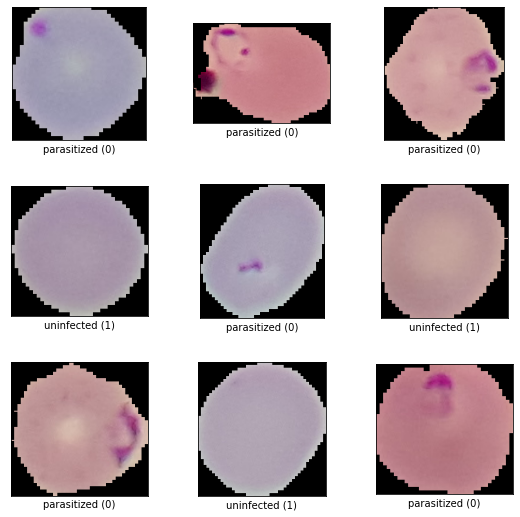

In [5]:
vis = tfds.visualization.show_examples(ds, info)

## Feature extraction

In order to perform feture selection we can represent data using numpy matrices

In [6]:
train_images = []
train_labels = []

for example in ds:
    train_images.append(example['image'].numpy())
    train_labels.append(example['label'].numpy())

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [8]:
print("Image:")
print(train_images[0])
print("Label: " + str(train_labels[0]))

Image:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Label: 1


As we see in our visualizations, not all of the images are of the same size. Additionally, our images will be a 3-channel matrix, meaning 3 matrices are stacked on top of each, one for each color of RGB. Sometimes, features of our image like size, length, and shape might strongly correlate with our labels.

Let's evaluate the length of our images.

In [9]:
images_flattened = [x.flatten().astype('float64') for x in train_images]

In [10]:
img_lengths = []

for img in images_flattened:
    img_lengths.append(len(img))

In [11]:
img_lengths = np.array(img_lengths)

Let's see our the lengths of the images identified as "uninfected" differ from the lengths of the images identifies as "parasitized".



In [12]:
uninfected_lengths = img_lengths[train_labels]
parasitized_lengths = img_lengths[train_labels == 0]

In [13]:
scipy.stats.describe(uninfected_lengths)

DescribeResult(nobs=27558, minmax=(31827, 38478), mean=35152.5, variance=11059351.561835468, skewness=0.0, kurtosis=-2.0)

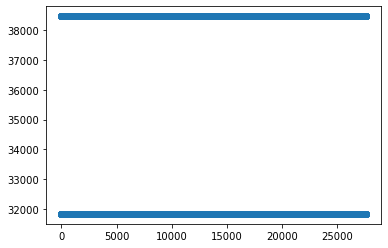

In [14]:
plt.scatter(np.arange(len(uninfected_lengths)), uninfected_lengths)

In [15]:
np.unique(uninfected_lengths)

array([31827, 38478])

We see that for the uninfected images, the length of the flattened image array is either 41745 or 54165. Now let's see the lengths of the parasitized images.

In [16]:
scipy.stats.describe(parasitized_lengths)

DescribeResult(nobs=13779, minmax=(6600, 371280), mean=54644.67798824298, variance=271685467.83177775, skewness=2.7492421162518896, kurtosis=26.067885001336347)

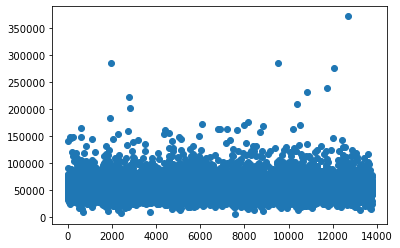

In [17]:
plt.scatter(np.arange(len(parasitized_lengths)), parasitized_lengths)

In [18]:
np.unique(parasitized_lengths)

array([  6600,   9048,   9660,  10902,  11136,  11163,  13224,  14016,
        14070,  14592,  15330,  15879,  15960,  16590,  16644,  17202,
        17220,  17301,  17850,  18012,  18615,  18696,  18723,  19110,
        19272,  19380,  19434,  19497,  20064,  20145,  20172,  20586,
        20748,  20856,  20910,  21243,  21567,  21648,  21675,  21900,
        22116,  22143,  22386,  22440,  22800,  22989,  23124,  23205,
        23214,  23232,  23700,  23862,  23871,  23970,  24024,  24411,
        24600,  24735,  24816,  24843,  24852,  25122,  25500,  25608,
        25662,  25833,  26076,  26220,  26265,  26400,  26481,  26508,
        26814,  27030,  27156,  27192,  27255,  27300,  27336,  27354,
        27795,  27966,  27984,  28119,  28200,  28227,  28272,  28290,
        28560,  28776,  28938,  29028,  29046,  29100,  29325,  29568,
        29757,  29766,  29892,  29973,  30000,  30090,  30360,  30504,
        30576,  30738,  30846,  30855,  30900,  31152,  31395,  31584,
      

For the parasitized lengths, we see that images are a wide variety of lengths. This will make it difficult to generalize the model as not all uninfected blood smear images are of the same size. To help prevent overfitting and to generalize our model, we will preprocess our images before inputing them.

We need to clean RAM first

In [19]:
del ds
del info
del train_images
del train_labels
del images_flattened
del img_lengths

gc.collect()

1607

# Model building

## Loading images

We load our images into three different datasets: a training dataset, a validation dataset, and a training dataset.

In [20]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteJLR3PV/malaria-train.tfrecord



Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


We will divide our data into 70:15:15 ratio. We can check that our ratios are correct by checking how many images are in each dataset.



In [21]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


## Reshape image input

Let's see the shapes of our images.

In [22]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  1


Not all the images are of size (200, 200). We need to pad the images in order to keep the same format for all of them, we can do it with tf library.

In [23]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

We have to use .map() to apply our padding method to all of our images. Batch job are useful here:

In [24]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

## Visualize padded images

In [25]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

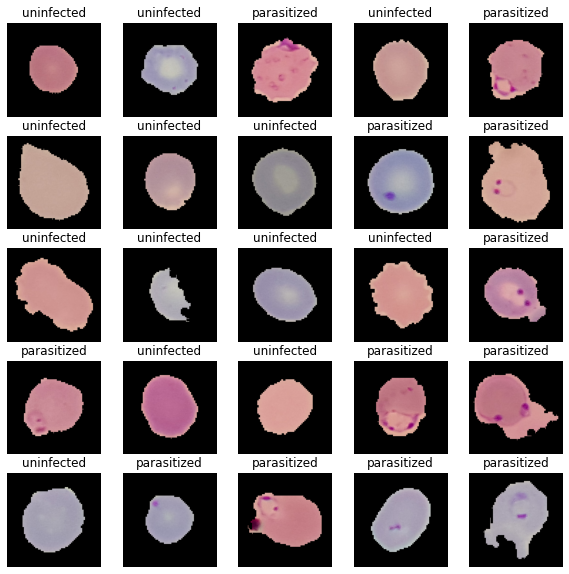

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Build our model

Let's build our deep CNN. We will be using the TensorFlow Keras API. We'll create two blocks, one convolution block and one dense block so we won't have to repeat our code.

In [27]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Now we'll define our model. We want our last layer to be a dense layer with a single node. The closer the value is to 1, the higher likelihood that the image is uninfected. Values closer to 0 indice a higher probability of being parasitized.

In [28]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

As we are working on a binary classification problem, we will be using a binary crossentropy loss function. We will be using AUC-ROC as our metric.

In [29]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.AUC(name='auc')
)

## Callbacks

We want to define certain callbacks so that we have the best model without overfitting.

We will do it by lowering th learning rate with exponential decay function.

In [30]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training

In [31]:
history = model.fit(
    padded_train_ds, epochs=20,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/20
603/603 [==============================] - 78s 129ms/step - loss: 0.6733 - auc: 0.6398 - val_loss: 0.7330 - val_auc: 0.6000 - lr: 0.0100
Epoch 2/20
603/603 [==============================] - 75s 124ms/step - loss: 0.6453 - auc: 0.6786 - val_loss: 0.6394 - val_auc: 0.6953 - lr: 0.0089
Epoch 3/20
603/603 [==============================] - 75s 124ms/step - loss: 0.6360 - auc: 0.6909 - val_loss: 0.8992 - val_auc: 0.4603 - lr: 0.0079
Epoch 4/20
603/603 [==============================] - 75s 124ms/step - loss: 0.6321 - auc: 0.6975 - val_loss: 1.0116 - val_auc: 0.4629 - lr: 0.0071
Epoch 5/20
603/603 [==============================] - 76s 126ms/step - loss: 0.6298 - auc: 0.7004 - val_loss: 0.8606 - val_auc: 0.7792 - lr: 0.0063
Epoch 6/20
603/603 [==============================] - 73s 122ms/step - loss: 0.1855 - auc: 0.9713 - val_loss: 0.1444 - val_auc: 0.9864 - lr: 0.0045
Epoch 9/20
603/603 [==============================] - 74s 123ms/step - loss: 0.1751 - auc: 0.9745 - val_loss: 0.

## Evaluate results

Let's preprocess our testing images.

In [32]:
padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

In [33]:
model.evaluate(padded_test_ds)

130/130 [==============================] - 5s 35ms/step - loss: 0.1519 - auc: 0.9804


[0.15192699432373047, 0.9803928136825562]

We see that our model has an AUC-ROC score of . A high AUC-ROC shows that our model works well at differentiating between parasitized and uninfected cells.

In [34]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
sequential (Sequential)      (None, 50, 50, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 25, 25, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 12, 12, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 128)      